In [75]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [76]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent.dcrnn import DCRNN

In [106]:
class DCRNNModel(torch.nn.Module):
    def __init__(self, node_features, out_channels, K):
        super(DCRNNModel, self).__init__()
        self.recurrent = DCRNN(node_features, out_channels, K)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight, h=None):
        h = self.recurrent(x, edge_index, edge_weight, h)
        h = F.relu(h)
        out = self.linear(h)
        return out

In [107]:
model = DCRNNModel(node_features=2, out_channels=32, K=3)


In [108]:
sample = a[0]
sample

Data(x=[325, 2, 1], edge_index=[2, 2694], edge_attr=[2694], y=[325, 2, 1])

In [109]:
sample.x.squeeze(2).shape

torch.Size([325, 2])

In [112]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(100):  # Adjust the number of epochs as necessary
    hidden_state = None
    for snapshot in train_dataset:
        x = torch.tensor(snapshot.x, dtype=torch.float32)
        edge_index = torch.tensor(snapshot.edge_index, dtype=torch.long)
        edge_weight = torch.tensor(snapshot.edge_weight, dtype=torch.float32)
        y = torch.tensor(snapshot.y, dtype=torch.float32)
        
        optimizer.zero_grad()
        y_hat, hidden_state = model(x, edge_index, edge_weight, hidden_state)
        loss = loss_function(y_hat, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

/var/folders/8b/qmk5d7kn5xv993tvmxwjdh5c0000gn/T/ipykernel_24803/3973878932.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(snapshot.x, dtype=torch.float32)
/var/folders/8b/qmk5d7kn5xv993tvmxwjdh5c0000gn/T/ipykernel_24803/3973878932.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(snapshot.edge_index, dtype=torch.long)


TypeError: must be real number, not NoneType

In [110]:
output = model(sample.x[:, :, 0], sample.edge_index, sample.edge_weight)

In [111]:
output.shape

torch.Size([325, 1])

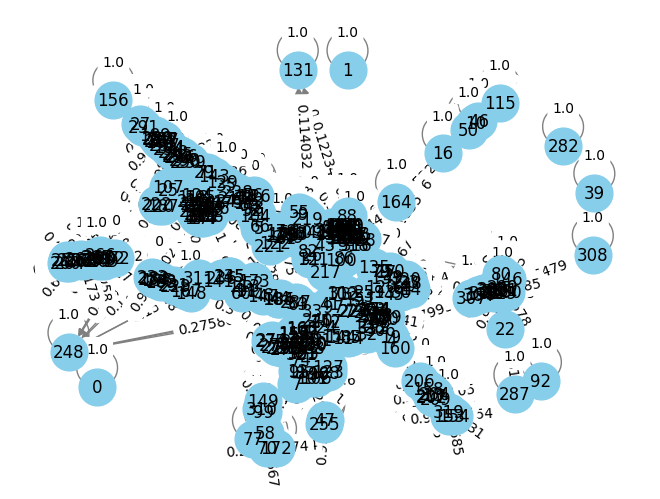

In [31]:
# plot the graph
import networkx as nx
import matplotlib.pyplot as plt

edge_index = sample.edge_index.numpy()
edge_attr = sample.edge_attr.numpy()

# Create a networkx graph
G = nx.DiGraph()

# Add edges and their attributes to the graph
for i in range(edge_index.shape[1]):
    u = edge_index[0, i]
    v = edge_index[1, i]
    G.add_edge(u, v, weight=edge_attr[i])

# Plot the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()